# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

# Setup libraries and parameters

In [179]:
import time
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [201]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import itertools

In [18]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

In [33]:
# Training settings
class Args:
    batch_size=128
    test_batch_size=1000
    epochs=12
    lr=0.01
    momentum=0.5
    no_cuda=False
    seed=1
    log_interval=117
    save_checkpoints=True
    load_checkpoint='mnist_012.pth'

args = Args

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [90]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        # weights = 1x8x3x3 = 72
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 64, 3, 1)
        # weights = 8x64x3x3 = 4,608
        self.drop1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(12*12*64, 128)
        # weights = 12x12x64x128 = 1,179,648
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        # weights = 128 x 10 = 1280

    def forward(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        fc2 = self.fc2(self.drop2(fc1))
        # layer size 1x10
        # perf = 1280 mul adds
        return F.log_softmax(fc2, dim=1)
    
    # Output fc1 features
    def features(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        return fc1

In [91]:
model = Net().to(device)

# Define the optimizer and loss criterion
I initially ran with SGD, but am now trying Adadelta. I haven't explicitly looked at what the loss is. Here is how Keras was set up:
```
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
```
I've switched to CrossEntropyLoss. I haven't validated that [Keras](https://keras.io/losses/) and [PyTorch](https://pytorch.org/docs/stable/nn.html#crossentropyloss) implement it the same.

In [36]:
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
optimizer = optim.Adadelta(model.parameters())
loss_criterion = nn.CrossEntropyLoss(reduction='sum')

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [37]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [38]:
# Generate a random input and run it forward
batch_size = 1
input = torch.randn(batch_size,1,28,28)
output = model(input)

# Run the backward pass, which generates the graph
model.zero_grad()
output.backward(torch.randn(batch_size,10))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| MulBackward0
||| ReluBackward0
|||| AddmmBackward
||||| AccumulateGrad
||||| ViewBackward
|||||| MulBackward0
||||||| MaxPool2DWithIndicesBackward
|||||||| ReluBackward0
||||||||| NativeBatchNormBackward
|||||||||| MkldnnConvolutionBackward
||||||||||| ReluBackward0
|||||||||||| NativeBatchNormBackward
||||||||||||| MkldnnConvolutionBackward
|||||||||||||| AccumulateGrad
|||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
|||||||||| AccumulateGrad
|||||||||| AccumulateGrad
||||| TBackward
|||||| AccumulateGrad
|| TBackward
||| AccumulateGrad


## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [39]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [40]:
 print_model_size(model)

Model's state_dict:
conv1.weight     torch.Size([8, 1, 3, 3])   : 8 x 9 = 72
conv1.bias       torch.Size([8])            : 8
bn1.weight       torch.Size([8])            : 8
bn1.bias         torch.Size([8])            : 8
bn1.running_mean torch.Size([8])            : 8
bn1.running_var  torch.Size([8])            : 8
conv2.weight     torch.Size([64, 8, 3, 3])  : 64 x 72 = 4,608
conv2.bias       torch.Size([64])           : 64
bn2.weight       torch.Size([64])           : 64
bn2.bias         torch.Size([64])           : 64
bn2.running_mean torch.Size([64])           : 64
bn2.running_var  torch.Size([64])           : 64
fc1.weight       torch.Size([128, 9216])    : 128 x 9216 = 1,179,648
fc1.bias         torch.Size([128])          : 128
fc2.weight       torch.Size([10, 128])      : 10 x 128 = 1,280
fc2.bias         torch.Size([10])           : 10

Total Model Size                            : 1,186,106


# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [467]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, **kwargs)

# Define the test and training functions

In [42]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Set model to be in training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))

In [43]:
def test(args, model, device, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [44]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch):
    train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, epoch)
    train_end = time.perf_counter()
    train_delta = train_end - train_start

    test_start = time.perf_counter()
    test(args, model, device, test_loader)
    test_end = time.perf_counter()
    test_delta = test_end - test_start
    
    print("Training took {:.1f}s.".format(train_delta))
    print("Testing took {:.1f}s.\n".format(test_delta))   

# Checkpointing Logic
This implementation is based on the [PyTorch reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html) 

In [45]:
def save_checkpoint(epoch, filepath='.', prefix='mnist_'):
    checkpoint = {'epoch' : epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict(),
                  'loss_criterion' : loss_criterion}
    torch.save(checkpoint, os.path.join(filepath, '{}{:03}.pth'.format(prefix, epoch)))
    
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_criterion = checkpoint['loss_criterion']
    for parameter in model.parameters():
        parameter.requires_grad = False

# Train (or load) the network

In [46]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(1, args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)


Test set: Average loss: 0.0380, Accuracy: 9897/10000 (99%)


# Visualization Code

### Plot data set entries

In [261]:
#plot some of the test data
def plot_data(dataset, entries):
    shp = np.shape(entries)
    width = shp[0]
    if len(shp) > 1:
        height = shp[1]
    else:
        height = 1
        
    entries_lst = np.reshape(entries,(width*height))
    
    targets = list(map(lambda idx: dataset.__getitem__(idx)[1], entries_lst))
    print('Labels:\n{}'.format(np.reshape(targets, shp)))

    fig, ax = plt.subplots(height,width)
    for row in range(0,height):
        if height>1:
            row_ax = ax[row]
        else:
            row_ax = ax            
        for col in range(0,width):
            idx = col + width*row
            im = row_ax[col].imshow(dataset.__getitem__(entries_lst[idx])[0].view(28,28), cmap='binary')
            row_ax[col].axis('off')
    plt.show()

## Test data

Labels:
[[7 2 1 0 4]
 [1 4 9 5 9]
 [0 6 9 0 1]
 [5 9 7 3 4]
 [9 6 6 5 4]]


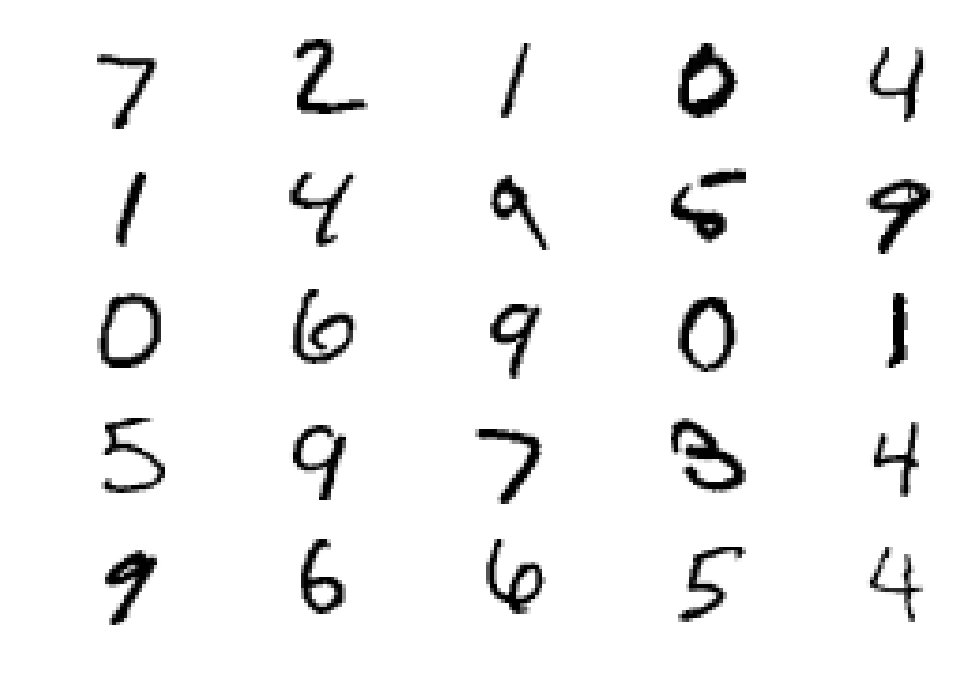

In [262]:
dim = 5
entries = np.reshape(range(0,dim*dim),(dim,dim))
plot_data(test_loader.dataset,entries)

## Training data

Labels:
[[5 0 4 1 9]
 [2 1 3 1 4]
 [3 5 3 6 1]
 [7 2 8 6 9]
 [4 0 9 1 1]]


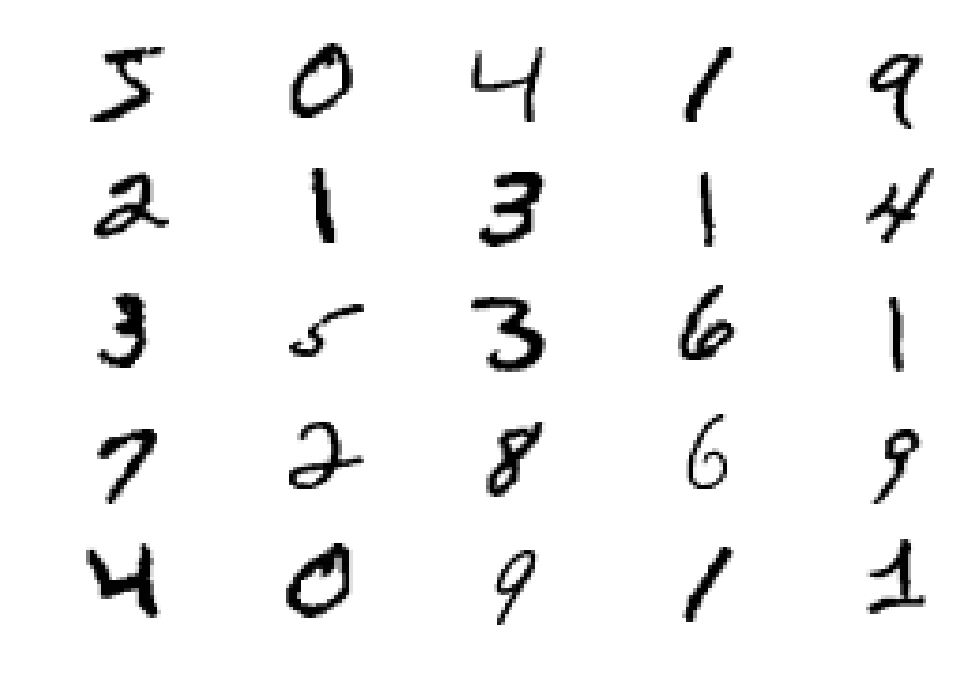

In [263]:
#plot some of the training data
entries = np.reshape(range(0,dim*dim),(dim,dim))
plot_data(train_loader.dataset, entries)

## Get Failures

In [19]:
def get_failures(model, device, test_loader):
    model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long)
    output_all = torch.zeros((0,10))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)))[0]
            failure_indices += list(idx + batch_offset)
            
            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

In [20]:
failure_indices, output_all, target_all = get_failures(model, device, test_loader)

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [504]:
import imageio

dl = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=args.test_batch_size, **kwargs)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

def get_img(idx):
    clr = cmap(dl.dataset[idx][1])
    img = dl.dataset[idx][0].numpy().reshape(28,28)*255
    return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

tiled = np.vstack([np.hstack([get_img(off+col) for col in range(100)]) for off in range(0, 10000, 100)])
imageio.imwrite('tiled.png', tiled)

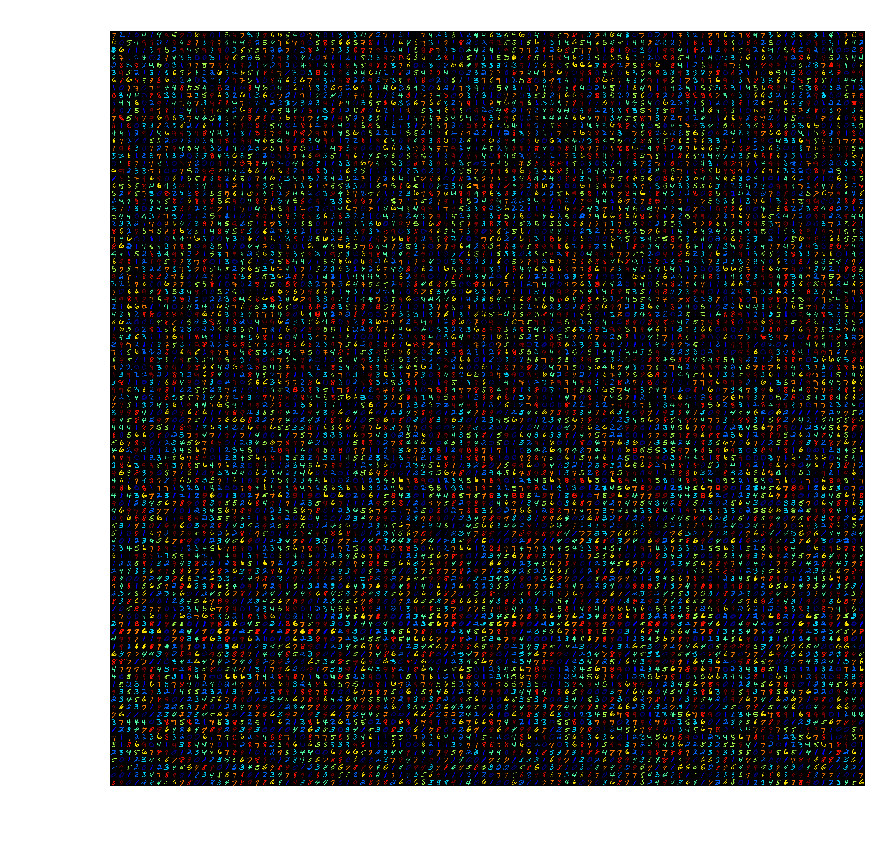

In [506]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [481]:
def get_fc1_features(model, device, dataloader):
    # Set model to be in testing mode
    model.eval()
    with torch.no_grad():
        x = list(map(lambda x: (model.features(x[0].to(device)), x[1].to(device)), dataloader))
        fc1 = torch.cat(list(map(lambda x: x[0], x))).detach().numpy()
        target = torch.cat(list(map(lambda x: x[1], x))).detach().numpy()
        return fc1, target

In [482]:
fc1, target=get_fc1_features(model, device, test_loader)

Embed the 128 dimensional fc1 features in 2D space

In [483]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

10000

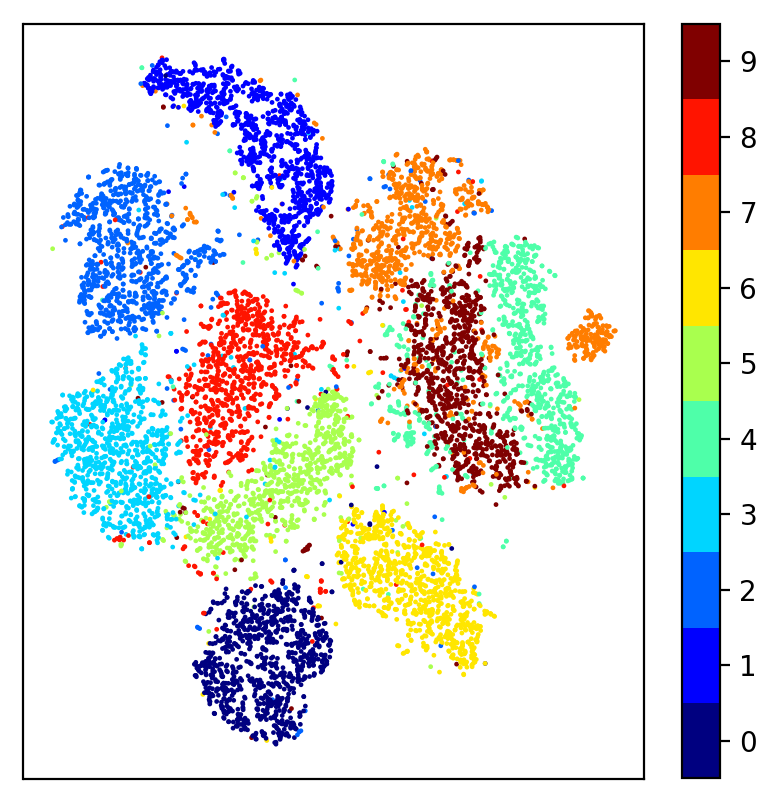

In [496]:
%matplotlib inline

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

fig, (ax0) = plt.subplots(1,1, figsize=(5,5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)

cs=ax0.scatter(X_embedded[:,0], X_embedded[:,1], s=.5, c=target, cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
cb = plt.colorbar(cs, ax=ax0)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])


#ax[1].set_xticks([])
#ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [313]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [314]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

3019

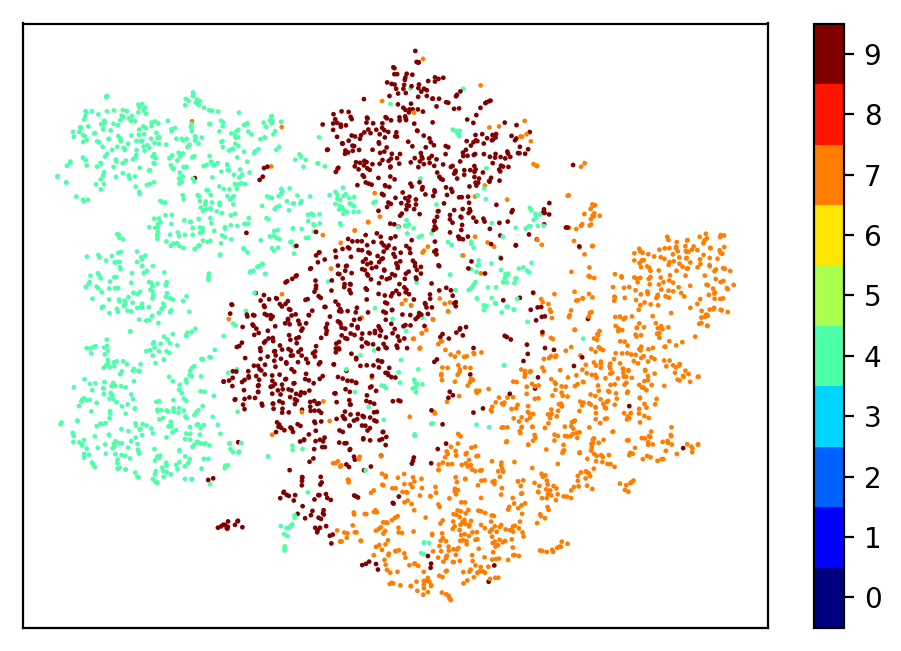

In [315]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

cs=plt.scatter(X_embedded_sub[:,0], X_embedded_sub[:,1], s=.5, c=target_sub, cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
cb = plt.colorbar(cs)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

plt.xticks([])
plt.yticks([])
len(target_sub)

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [251]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

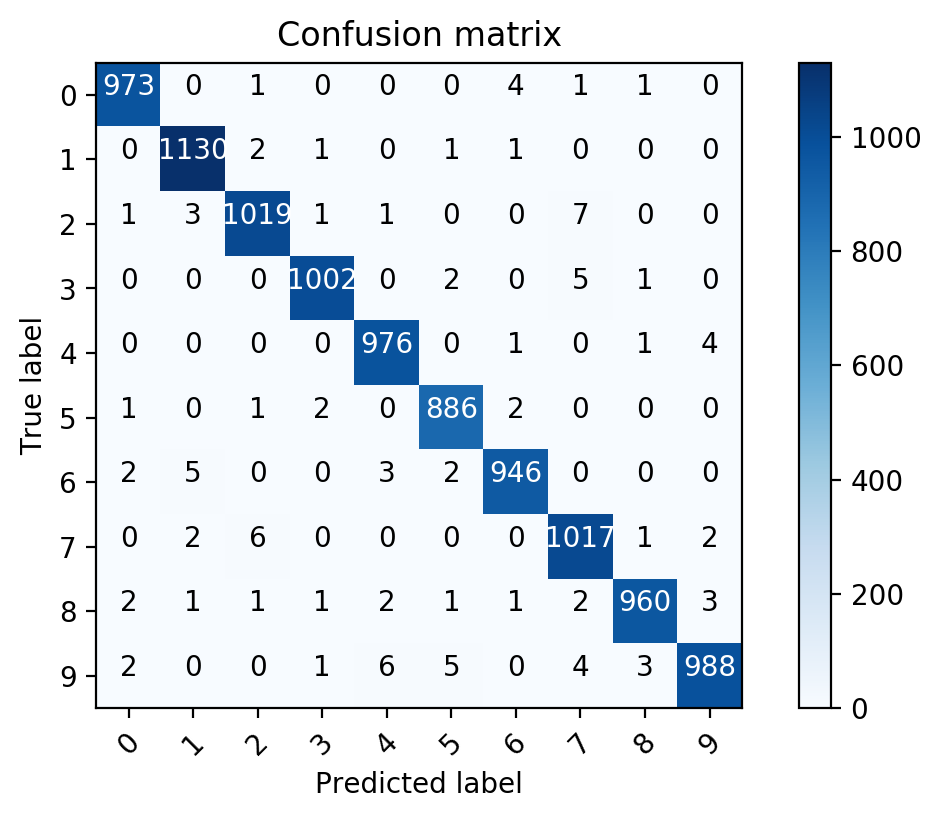

In [252]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all, pred_all) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Plot All Failures

7 failures for digit 0
Classification:
[6 6 6 7 8 6 2]
Labels:
[0 0 0 0 0 0 0]


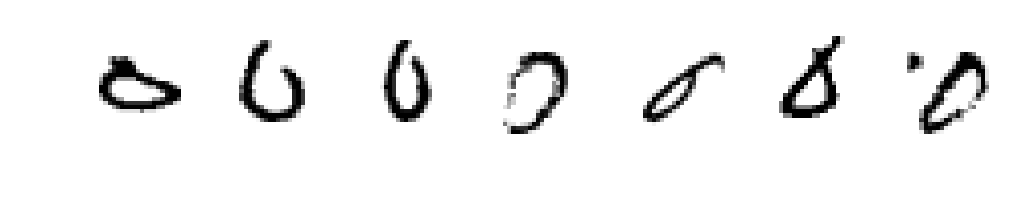

5 failures for digit 1
Classification:
[5 3 6 2 2]
Labels:
[1 1 1 1 1]


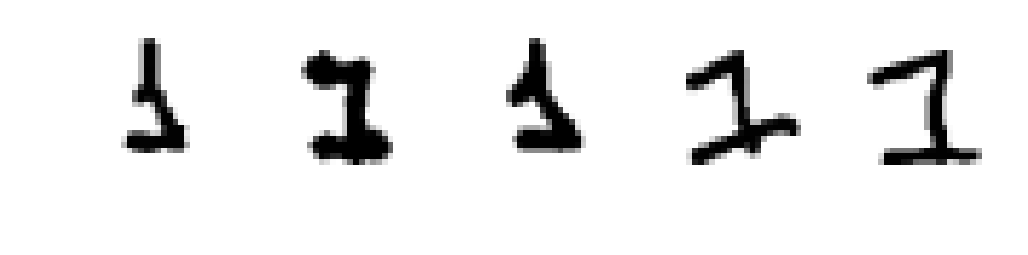

13 failures for digit 2
Classification:
[7 1 7 7 0 3 7 4 7 1 1 7 7]
Labels:
[2 2 2 2 2 2 2 2 2 2 2 2 2]


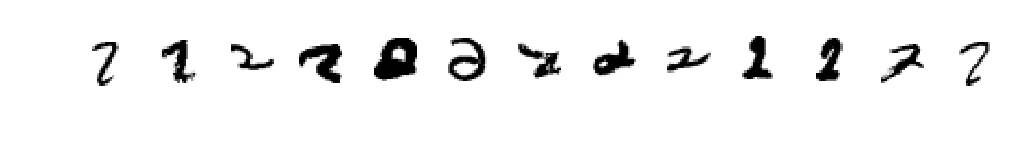

8 failures for digit 3
Classification:
[5 7 7 7 5 8 7 7]
Labels:
[3 3 3 3 3 3 3 3]


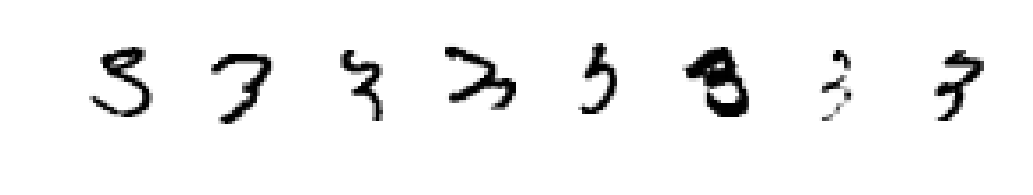

6 failures for digit 4
Classification:
[9 9 8 9 6 9]
Labels:
[4 4 4 4 4 4]


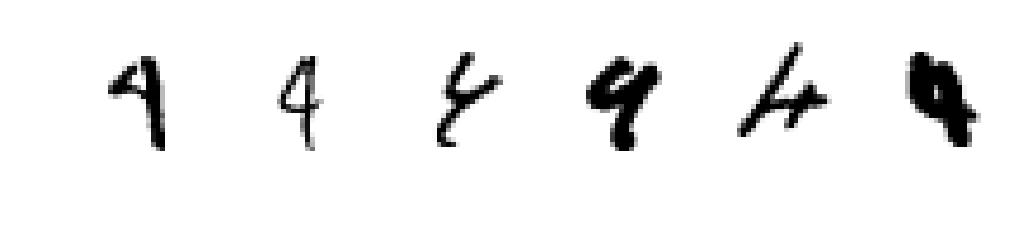

6 failures for digit 5
Classification:
[3 0 2 3 6 6]
Labels:
[5 5 5 5 5 5]


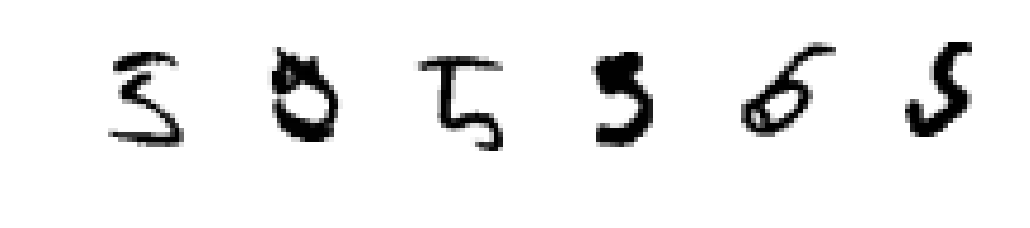

12 failures for digit 6
Classification:
[0 5 1 4 1 4 5 1 0 4 1 1]
Labels:
[6 6 6 6 6 6 6 6 6 6 6 6]


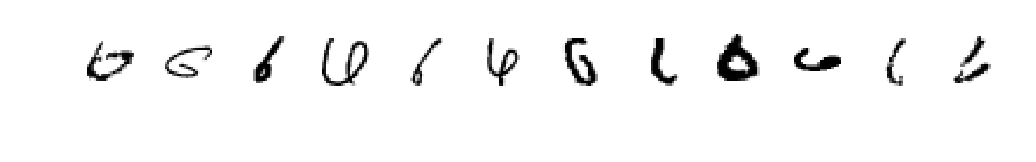

11 failures for digit 7
Classification:
[2 2 1 2 9 2 8 9 1 2 2]
Labels:
[7 7 7 7 7 7 7 7 7 7 7]


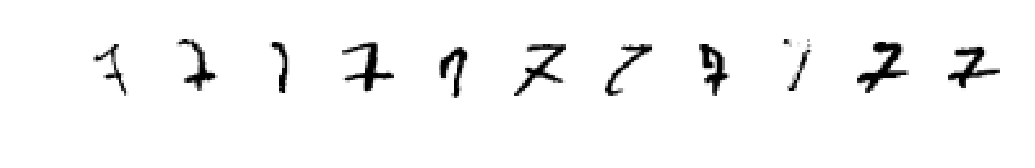

14 failures for digit 8
Classification:
[2 9 7 3 0 6 7 4 9 0 4 9 1 5]
Labels:
[8 8 8 8 8 8 8 8 8 8 8 8 8 8]


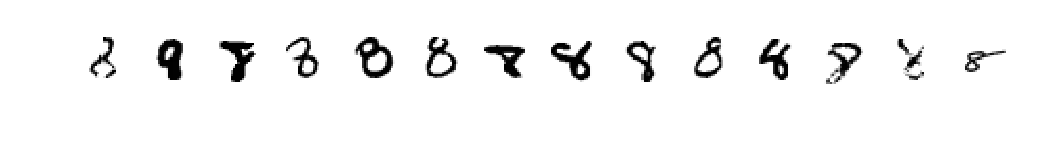

21 failures for digit 9
Classification:
[4 5 5 4 8 8 0 4 4 5 7 4 8 4 5 3 5 0 7 7 7]
Labels:
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


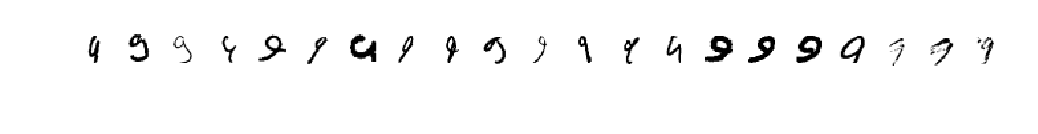

In [265]:
target_failures = target_all[failure_indices]

failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit))[0], range(0,10)))

for digit in range(0,10):
    fail_idx = failure_indices[failure_idx_by_digit[digit]]
    print('{} failures for digit {}'.format(fail_idx.size, digit))
    output = output_all[fail_idx].argmax(dim=1, keepdim=True).numpy().T[0]
    print('Classification:\n{}'.format(output))
    plot_data(test_loader.dataset, fail_idx)

In [256]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]
    #np.linalg.svd()

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

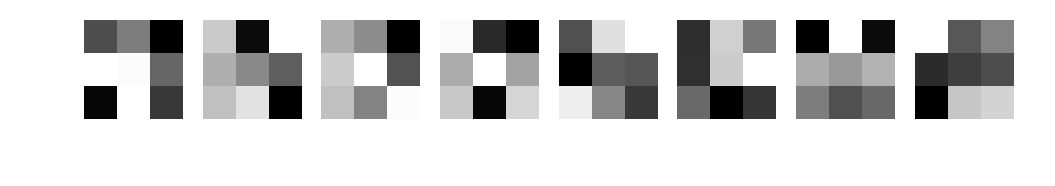

In [271]:
plot_kernels(model.state_dict()['conv1.weight'].permute(1,0,2,3))

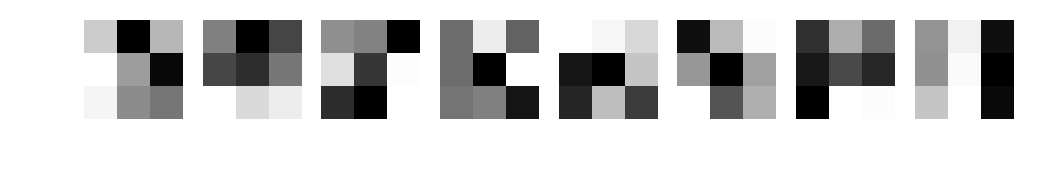

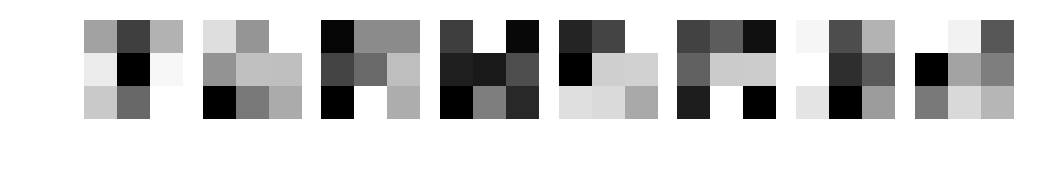

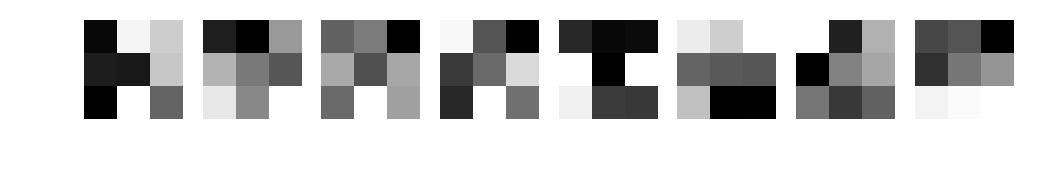

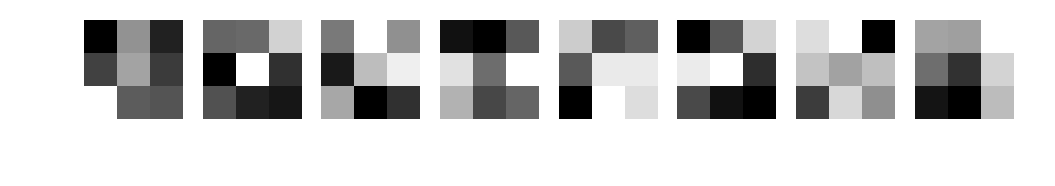

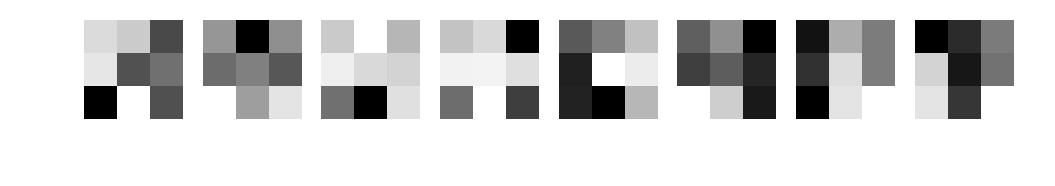

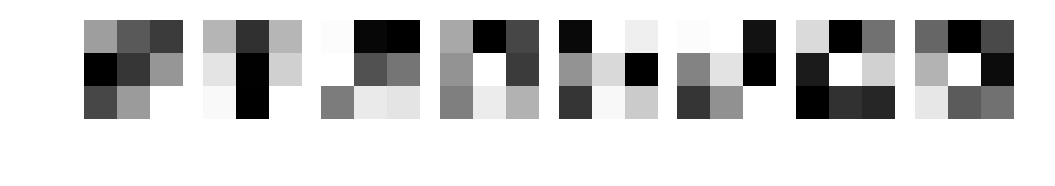

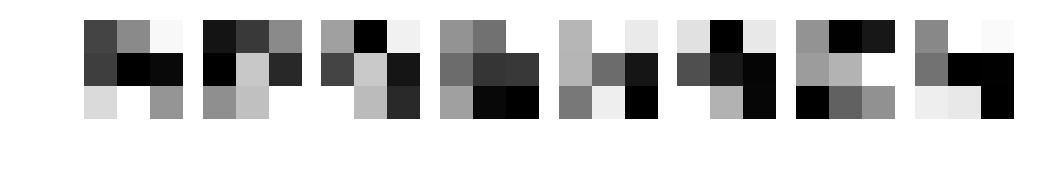

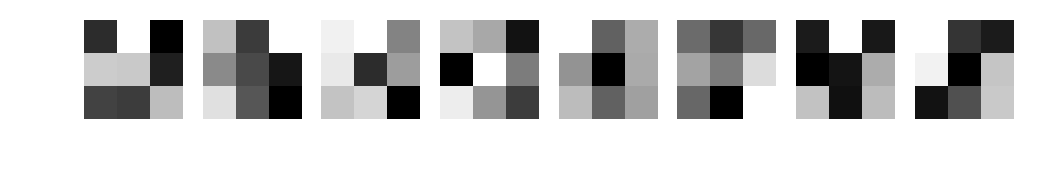

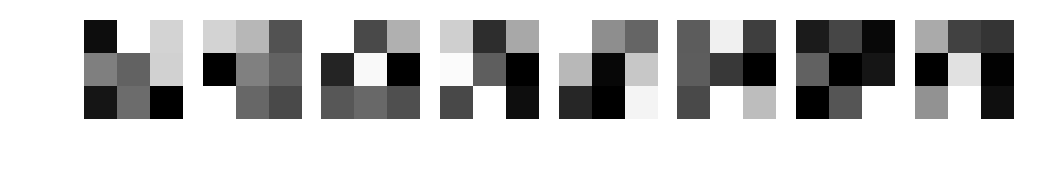

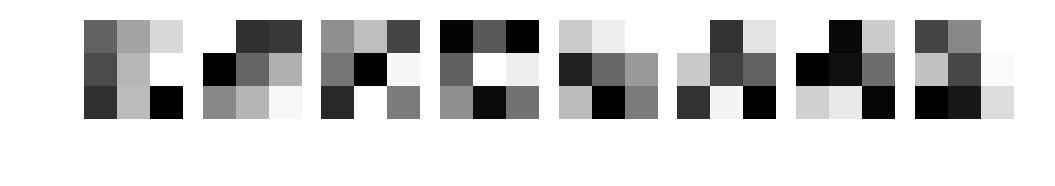

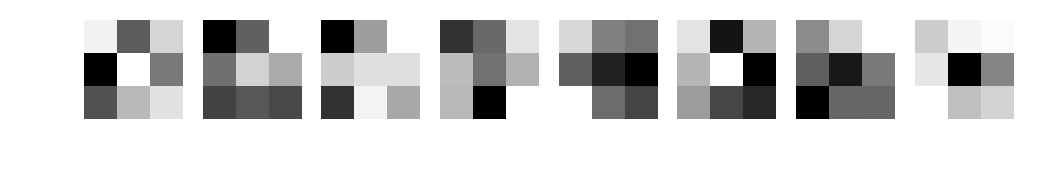

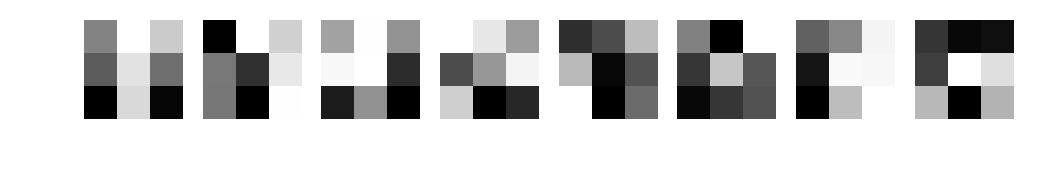

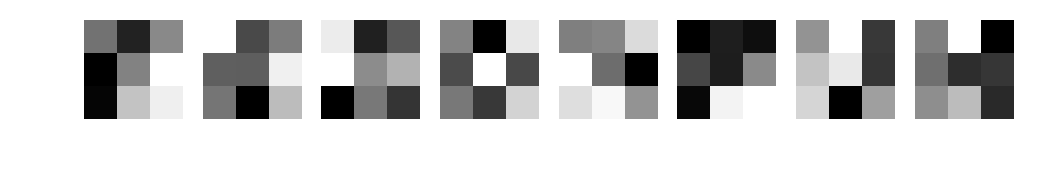

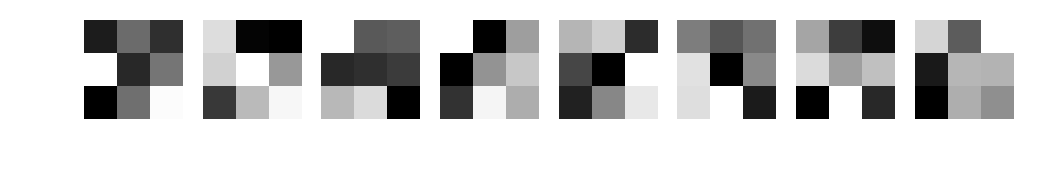

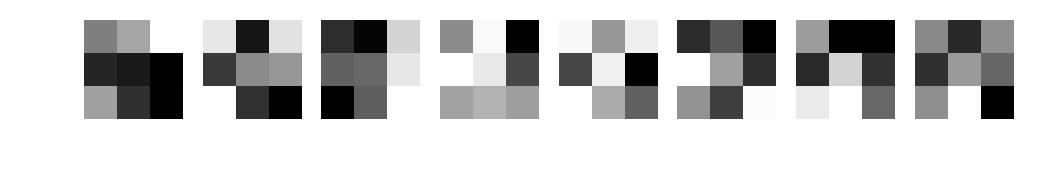

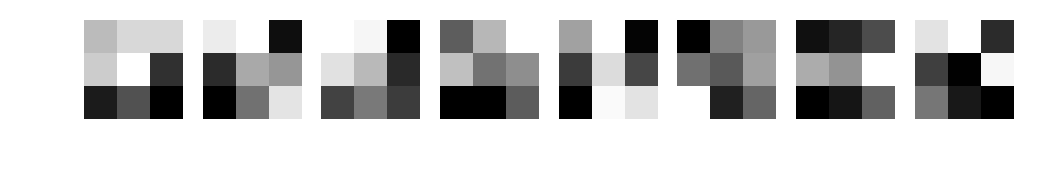

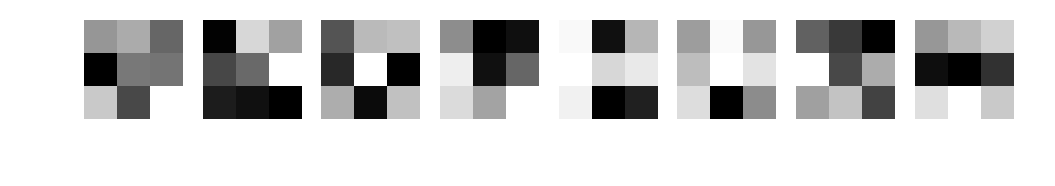

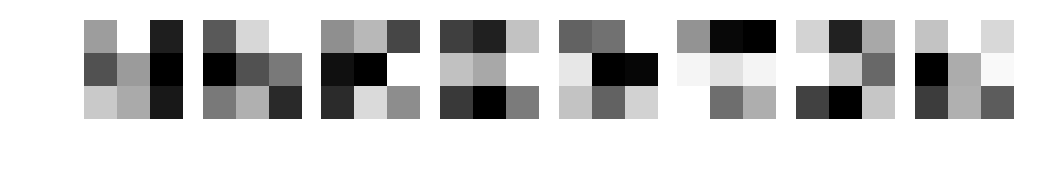

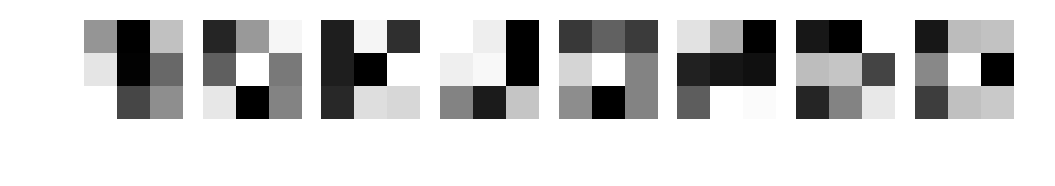

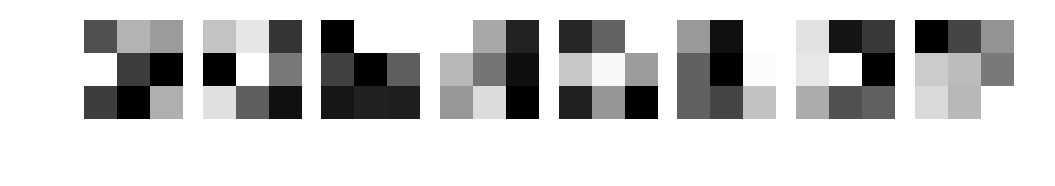

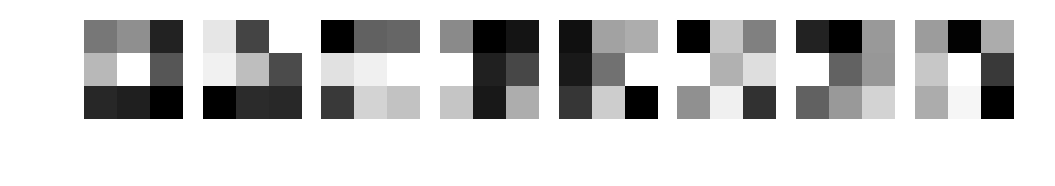

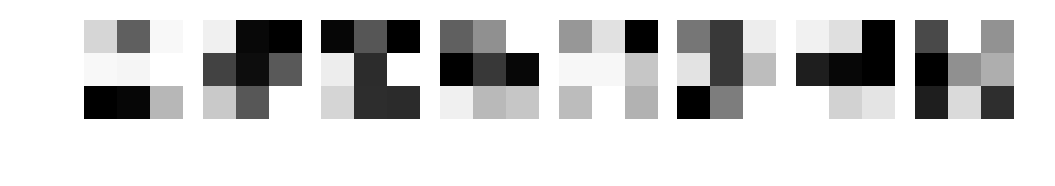

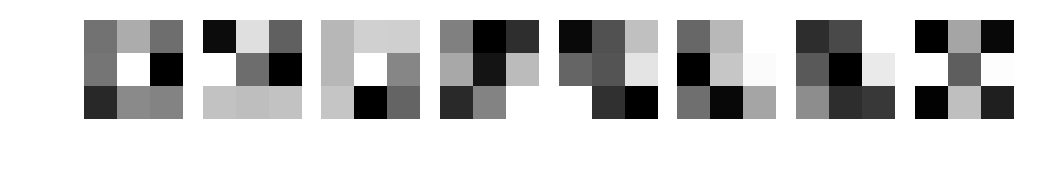

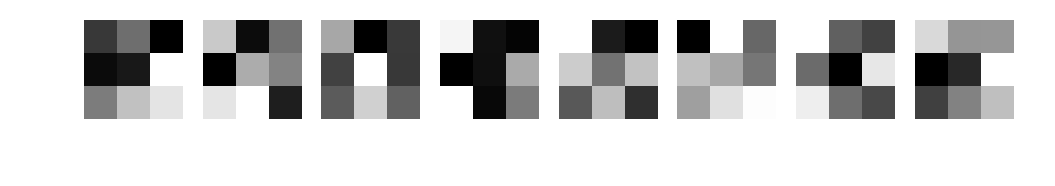

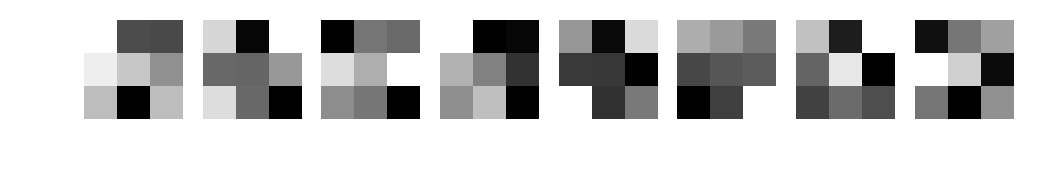

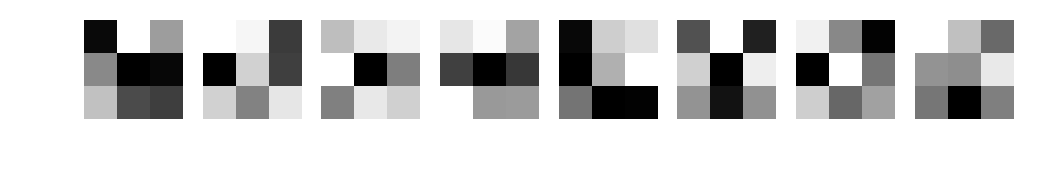

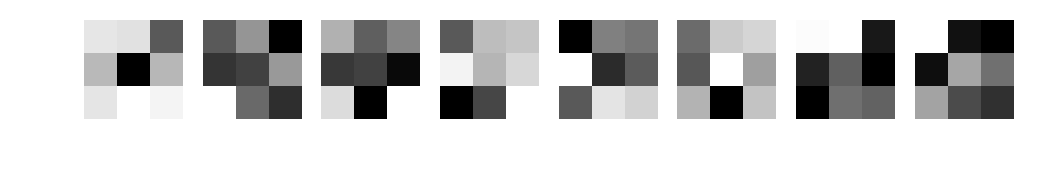

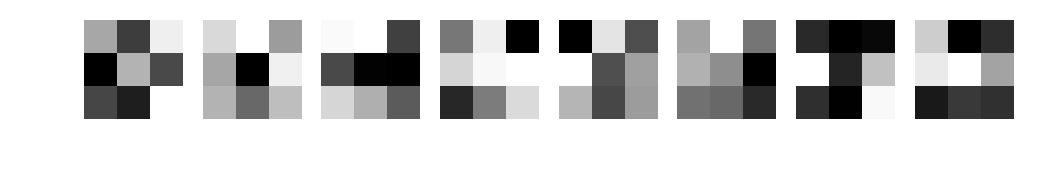

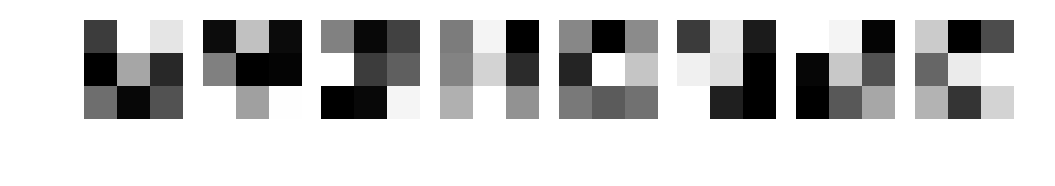

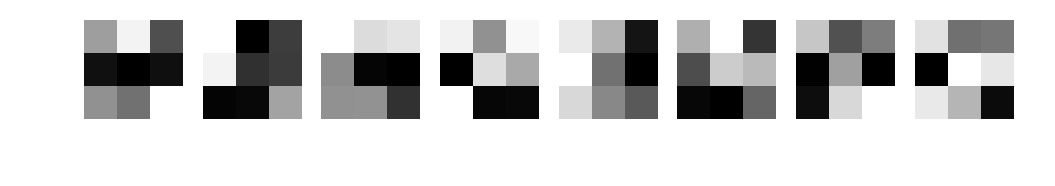

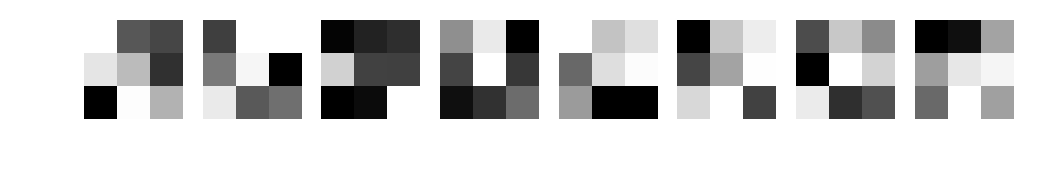

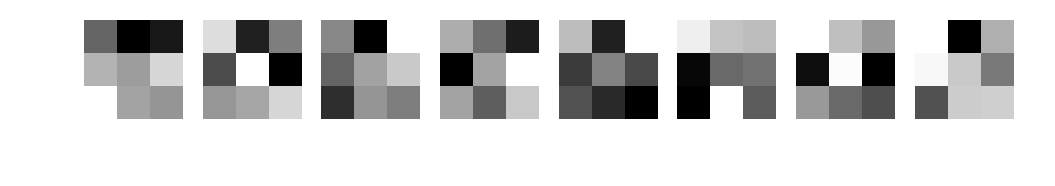

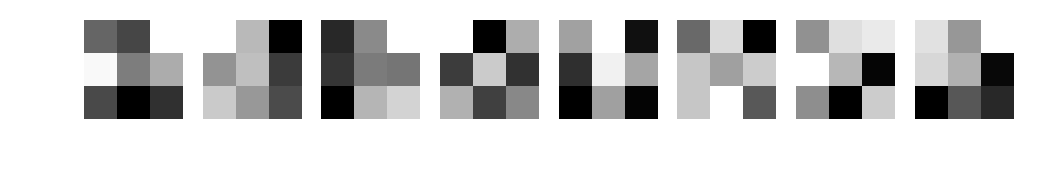

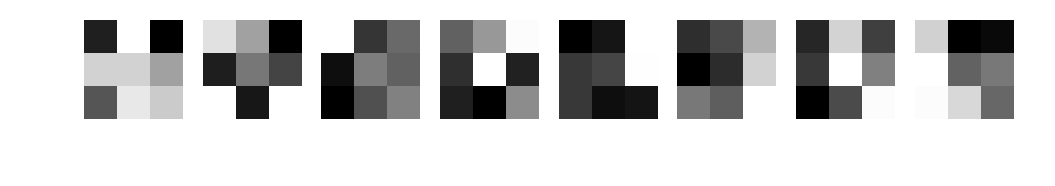

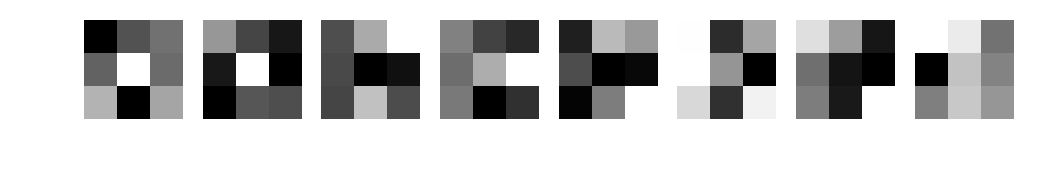

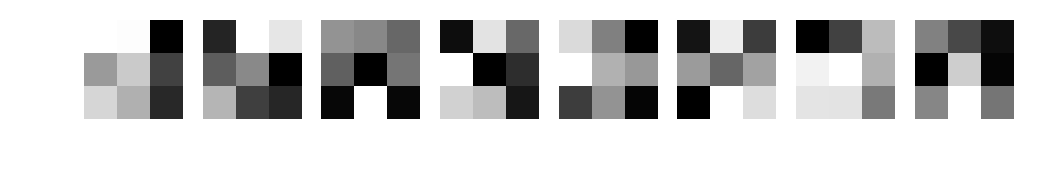

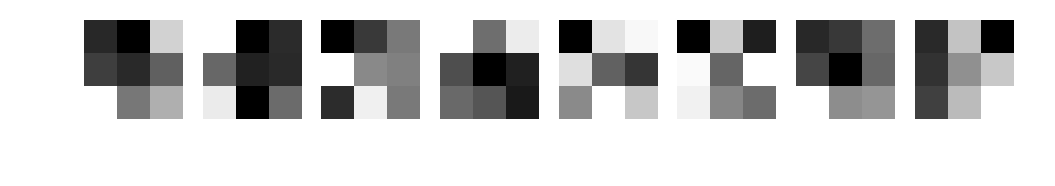

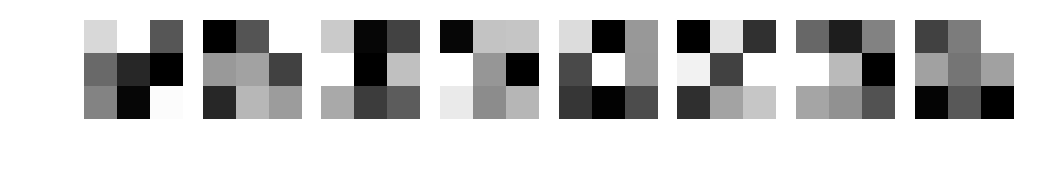

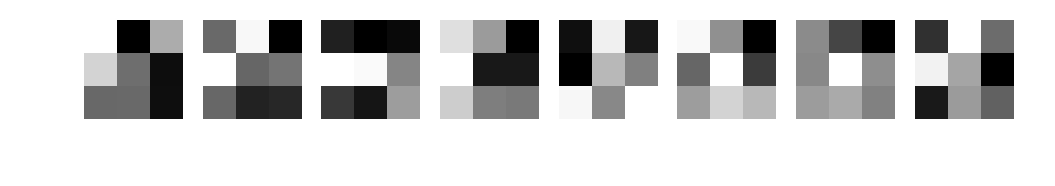

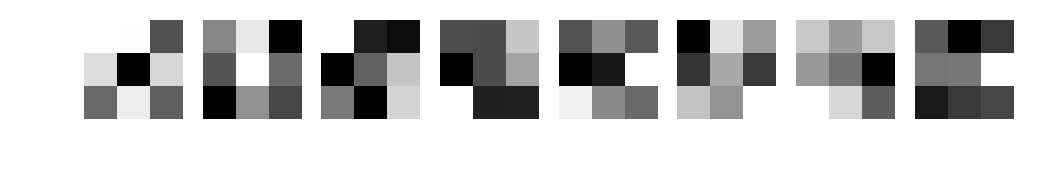

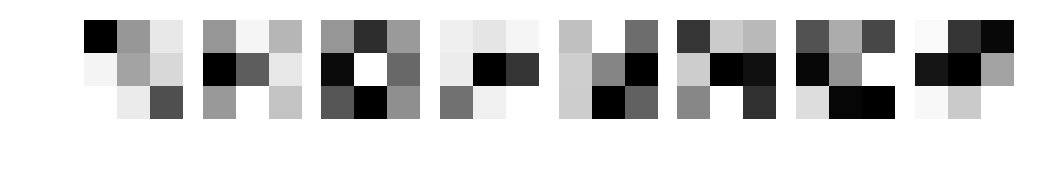

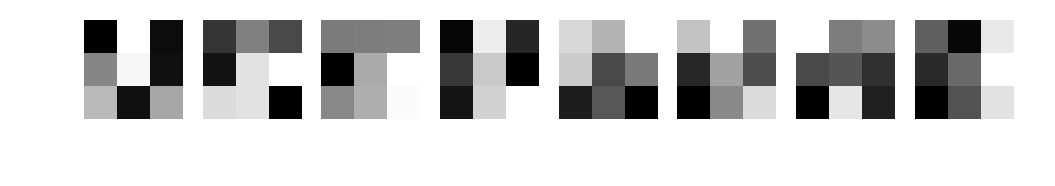

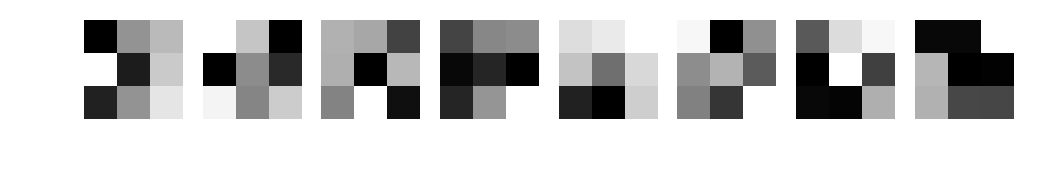

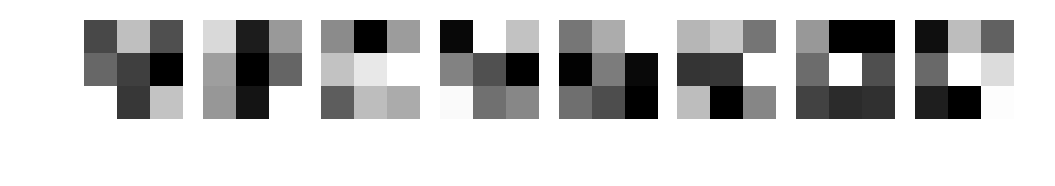

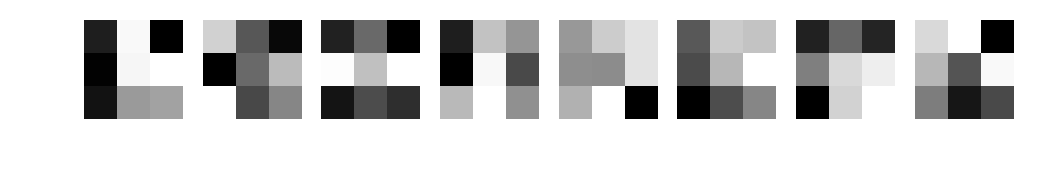

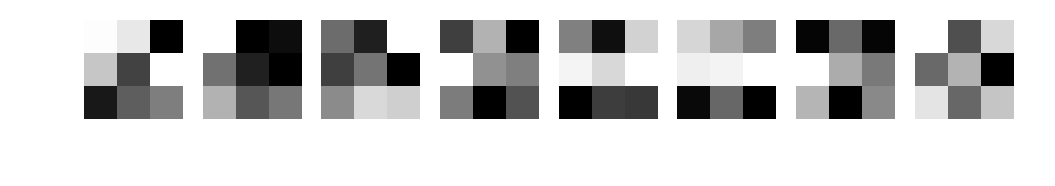

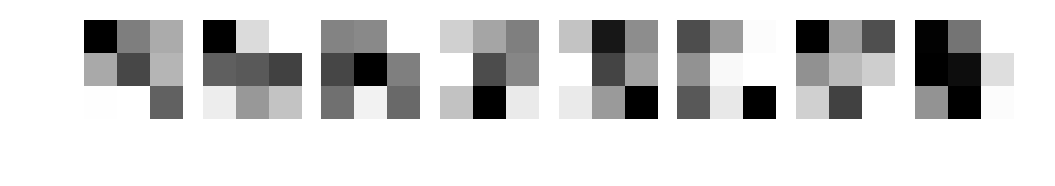

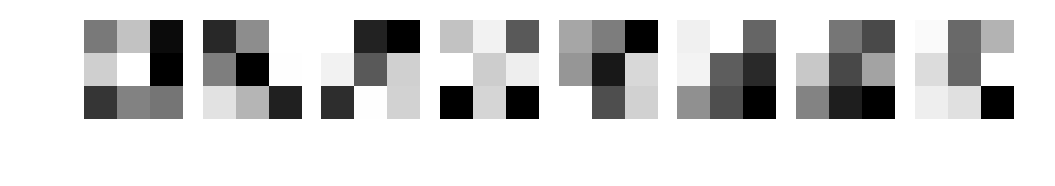

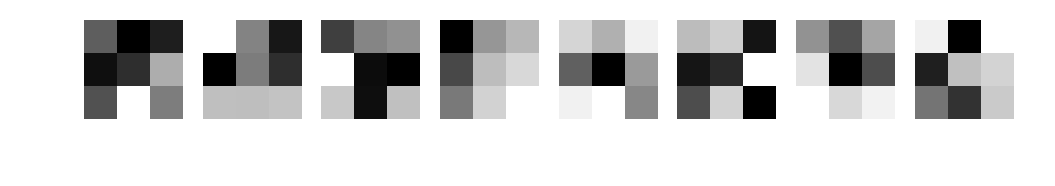

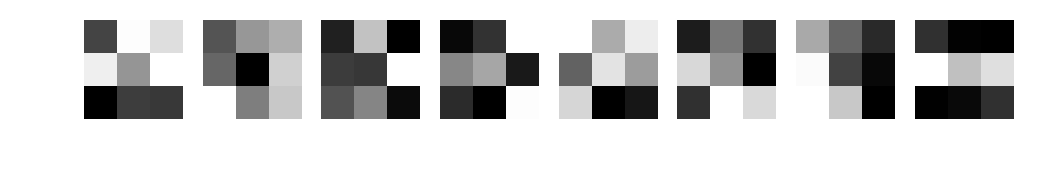

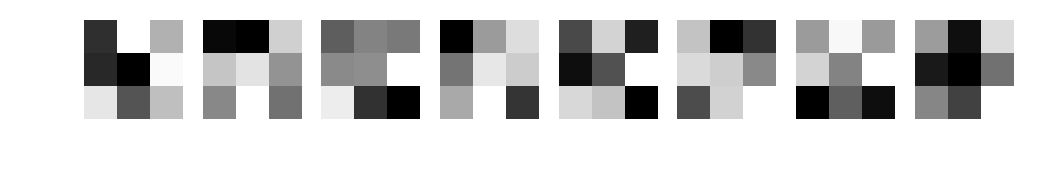

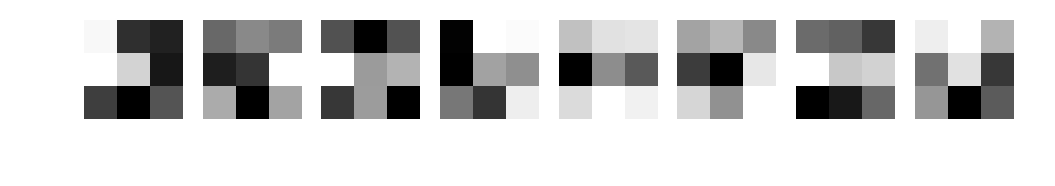

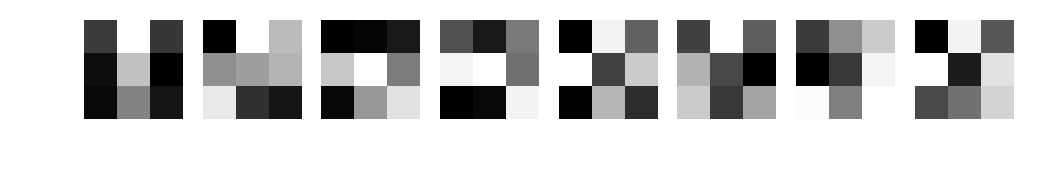

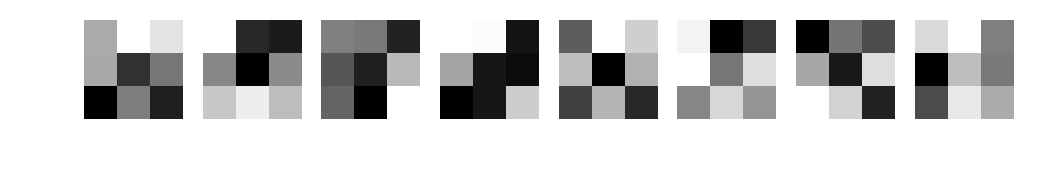

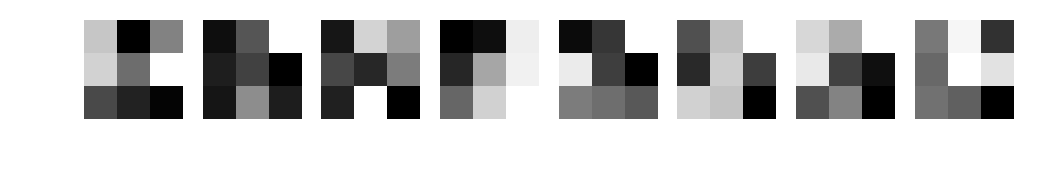

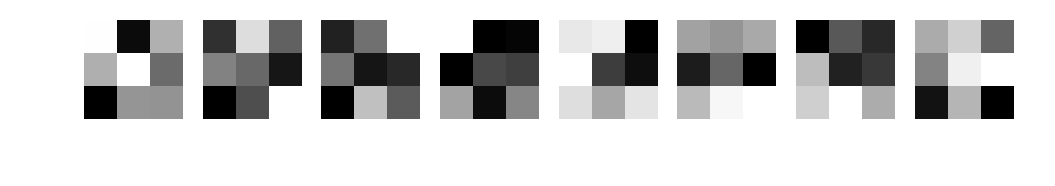

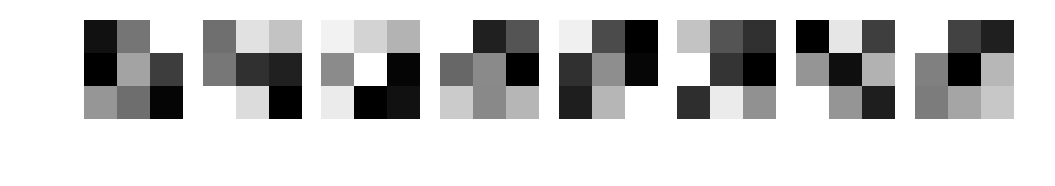

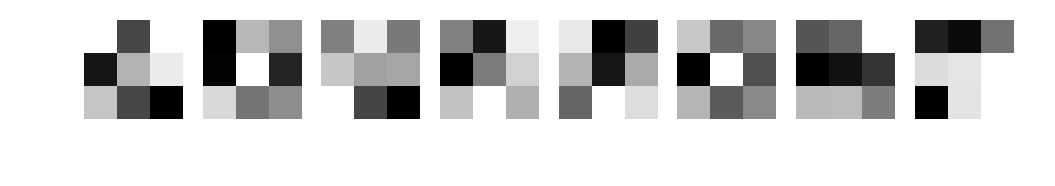

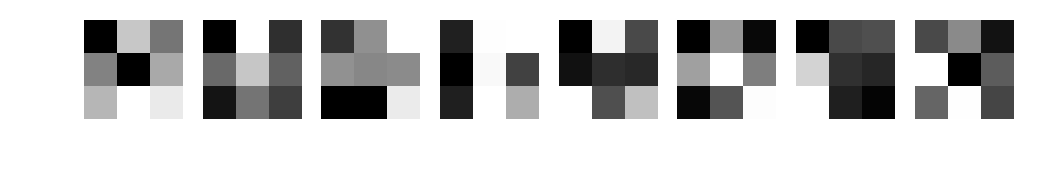

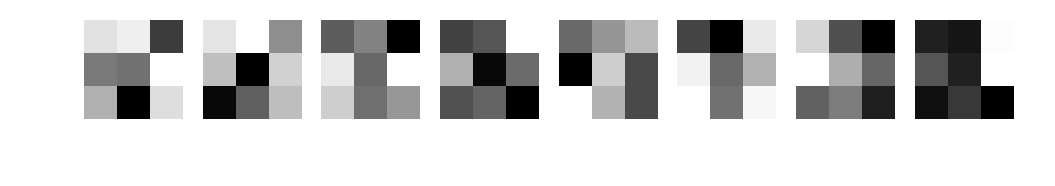

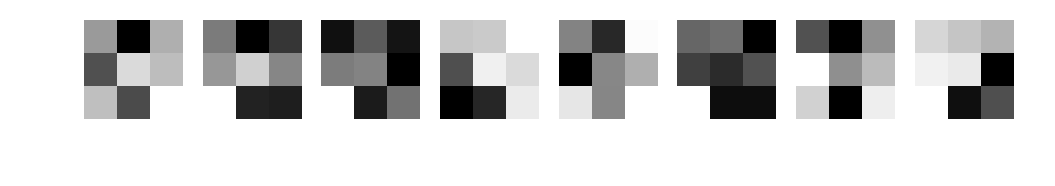

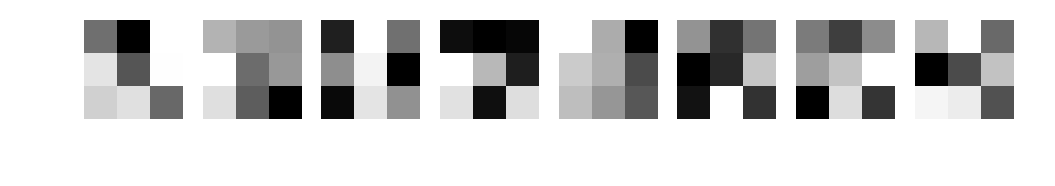

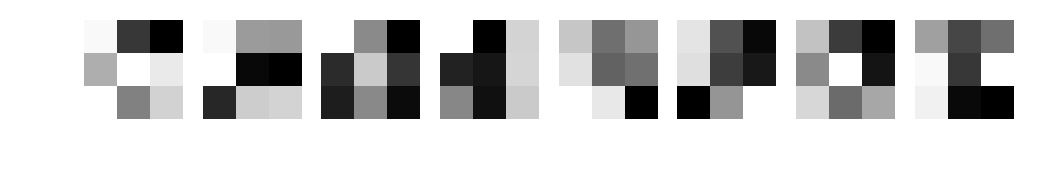

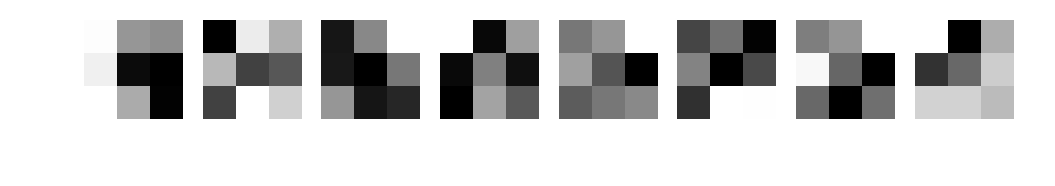

In [258]:
plot_kernels(model.state_dict()['conv2.weight'])